# Graph Memory — Clean Viz + Gephi Export

Ten notebook rysuje **czytelny** lokalny podgraf oraz eksportuje do **Gephi (GEXF)**.

In [1]:

# Install deps if missing
import sys, subprocess
def ensure(pkg):
    try: __import__(pkg)
    except Exception:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])
for p in ["numpy", "networkx", "matplotlib", "pydantic"]:
    ensure(p)
print("✅ Deps OK")


✅ Deps OK


In [2]:

# Detect repo with tools/faq_generator/parser.py and data/banking_faq_30plus.txt
from pathlib import Path
import sys
REPO_ROOT = Path.cwd()
def ok(root: Path):
    return (root/"tools/faq_generator/parser.py").exists() and (root/"data/banking_faq_30plus.txt").exists()
cands = [REPO_ROOT] + [p for p in REPO_ROOT.iterdir() if p.is_dir()]
chosen = None
for c in cands:
    if ok(c):
        chosen = c.resolve(); break
if chosen is None:
    raise FileNotFoundError("Run from repo root containing tools/faq_generator/parser.py and data/banking_faq_30plus.txt")
REPO_ROOT = chosen
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))
REPO_ROOT


PosixPath('/home/jupyter/olga_zydziak/version_beta/Folder/chatbot-simple')

In [3]:

# Ingest FAQ -> GraphMem
from graph_mem import GraphMem
try:
    from adapters import faq_ingest_adapter as ingest  # type: ignore
except Exception:
    from adapter import faq_ingest_adapter as ingest  # type: ignore
faq_path = REPO_ROOT/"data/banking_faq_30plus.txt"
gm = GraphMem(tau=0.35, k=5, alpha=0.7)
ingest.ingest_faq_to_graph(str(faq_path), gm)
print("Facts:", len(gm.facts))


Facts: 32


In [4]:

# Tools: build_subgraph, draw_graph, export_gexf, export_full_graph_gexf
import re, textwrap, time, json
import networkx as nx
import matplotlib.pyplot as plt

def _label_from_text(text: str, mode: str = "category", width: int = 28) -> str:
    lines = [ln for ln in (text or "").splitlines() if ln.strip()]
    if mode == "question":
        for ln in lines:
            if ln.strip().lower().startswith("q:"):
                return "\n".join(textwrap.wrap(ln[2:].strip(), width=width))
    label = lines[0] if lines else ""
    return "\n".join(textwrap.wrap(label, width=width))

def build_local_subgraph(gm, query: str, top_k: int = 6, min_w: float = 0.8, edges_per_node: int = 2, label_mode: str = "category"):
    res = gm.retrieve(query, now_ts=time.time(), k=top_k)
    nodes = set()
    for f in res:
        i = gm.facts.index(f)
        nodes.add(i)
        for j, _ in gm.facts[i].neigh:
            nodes.add(j)
    G = nx.DiGraph()
    for i in nodes:
        meta = getattr(gm.facts[i], "meta", {}) if hasattr(gm.facts[i], "meta") else {}
        G.add_node(i, label=_label_from_text(gm.facts[i].text, mode="question", width=20))

    for i in nodes:
        neigh_sorted = sorted(gm.facts[i].neigh, key=lambda x: -x[1])
        kept = 0
        for j, w in neigh_sorted:
            if j not in nodes or w < min_w: continue
            G.add_edge(i, j, weight=float(w))
            kept += 1
            if kept >= edges_per_node: break
    iso = [n for n in list(G.nodes()) if G.degree(n) == 0]
    G.remove_nodes_from(iso)
    return G

def draw_graph(G, layout: str = "kk", show_edge_labels: bool = False, seed: int = 7, title: str = ""):
    if G.number_of_nodes() == 0:
        print("Empty graph"); return
    pos = nx.kamada_kawai_layout(G) if layout=="kk" else nx.spring_layout(G, seed=seed)
    deg = dict(G.degree())
    node_sizes = [400 + 120*deg[n] for n in G.nodes()]
    edge_widths = [1.0 + 4.0*d.get("weight",0) for _,_,d in G.edges(data=True)]
    plt.figure()
    nx.draw(G, pos,
        labels={n: G.nodes[n].get("label", str(n)) for n in G.nodes()},
        node_size=node_sizes,
        width=edge_widths,
        arrows=True,
        with_labels=True,
        font_size=8,           # mniejsze czcionki
        font_color="black",
        font_weight="bold",
        node_color="#4ea3d5")
    if show_edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels={(u,v):f'{d.get("weight",0):.2f}' for u,v,d in G.edges(data=True)})
    plt.title(title or "Graph"); plt.show()

def export_gexf(G, path: str):
    nx.write_gexf(G, path); print("GEXF saved:", path)

def export_full_graph_gexf(gm, path: str, min_w: float = 0.70, max_nodes: int | None = 2000, label_mode: str = "category"):
    G = nx.DiGraph()
    N = len(gm.facts)
    indices = range(N if not max_nodes else min(N, max_nodes))
    for i in indices:
        meta = getattr(gm.facts[i], "meta", {}) if hasattr(gm.facts[i], "meta") else {}
        G.add_node(i, label=_label_from_text(gm.facts[i].text, mode=label_mode), text=gm.facts[i].text, ts=float(gm.facts[i].ts), **({k: json.dumps(v) if isinstance(v,(list,dict)) else v for k,v in meta.items()}))
    for i in indices:
        for j, w in gm.facts[i].neigh:
            if max_nodes and j>=max_nodes: continue
            if w>=min_w: G.add_edge(i,j,weight=float(w))
    nx.write_gexf(G, path); print("Full GEXF saved:", path)


In [11]:
import matplotlib.pyplot as plt
import networkx as nx

def draw_graph_pretty(
    G,
    layout: str = "kk",        # 'kk' (Kamada–Kawai) | 'spring'
    font_size: int = 9,
    show_edge_labels: bool = False,
    seed: int = 7,
    title: str = "",
):
    """Rysuje graf z wyraźnymi etykietami (osobne warstwy; kompatybilne z różnymi wersjami NX/Matplotlib)."""
    if G.number_of_nodes() == 0:
        print("Graf pusty.")
        return

    # 1) Układ
    pos = nx.kamada_kawai_layout(G) if layout == "kk" else nx.spring_layout(G, seed=seed)

    # 2) Skale
    deg = dict(G.degree())
    node_sizes = [400 + 120 * deg[n] for n in G.nodes()]
    edge_widths = [1.0 + 4.0 * G.edges[u, v].get("weight", 0.0) for u, v in G.edges()]

    # 3) Rysunek
    plt.figure(figsize=(12, 8), dpi=150)

    # Edges
    edge_artists = nx.draw_networkx_edges(
        G, pos,
        width=edge_widths,
        arrows=True, arrowstyle="-|>", arrowsize=14,
        edge_color="black", alpha=0.95,
    )
    # niektóre wersje zwracają listę kolekcji, inne pojedynczą kolekcję
    if edge_artists is not None:
        try:
            for coll in edge_artists:
                coll.set_zorder(1)
        except TypeError:
            edge_artists.set_zorder(1)

    # Nodes
    node_artist = nx.draw_networkx_nodes(
        G, pos,
        node_size=node_sizes,
        node_color="#4ea3d5",
        linewidths=0.5, edgecolors="#1f4b6e",
    )
    try:
        node_artist.set_zorder(2)
    except Exception:
        pass

    # Labels (węzłów) – osobno + białe tło
    labels = {n: G.nodes[n].get("label", str(n)) for n in G.nodes()}
    text_artists = nx.draw_networkx_labels(
        G, pos,
        labels=labels,
        font_size=font_size, font_color="black",
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=1.2),
    )
    # podnieś nad węzły
    for t in (text_artists.values() if isinstance(text_artists, dict) else []):
        t.set_zorder(3)

    # (opcjonalnie) etykiety krawędzi
    if show_edge_labels:
        elbl = {(u, v): f'{G.edges[u, v].get("weight", 0):.2f}' for u, v in G.edges()}
        elbl_art = nx.draw_networkx_edge_labels(
            G, pos, edge_labels=elbl, font_size=8,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.6)
        )

    plt.title(title or "Graf")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


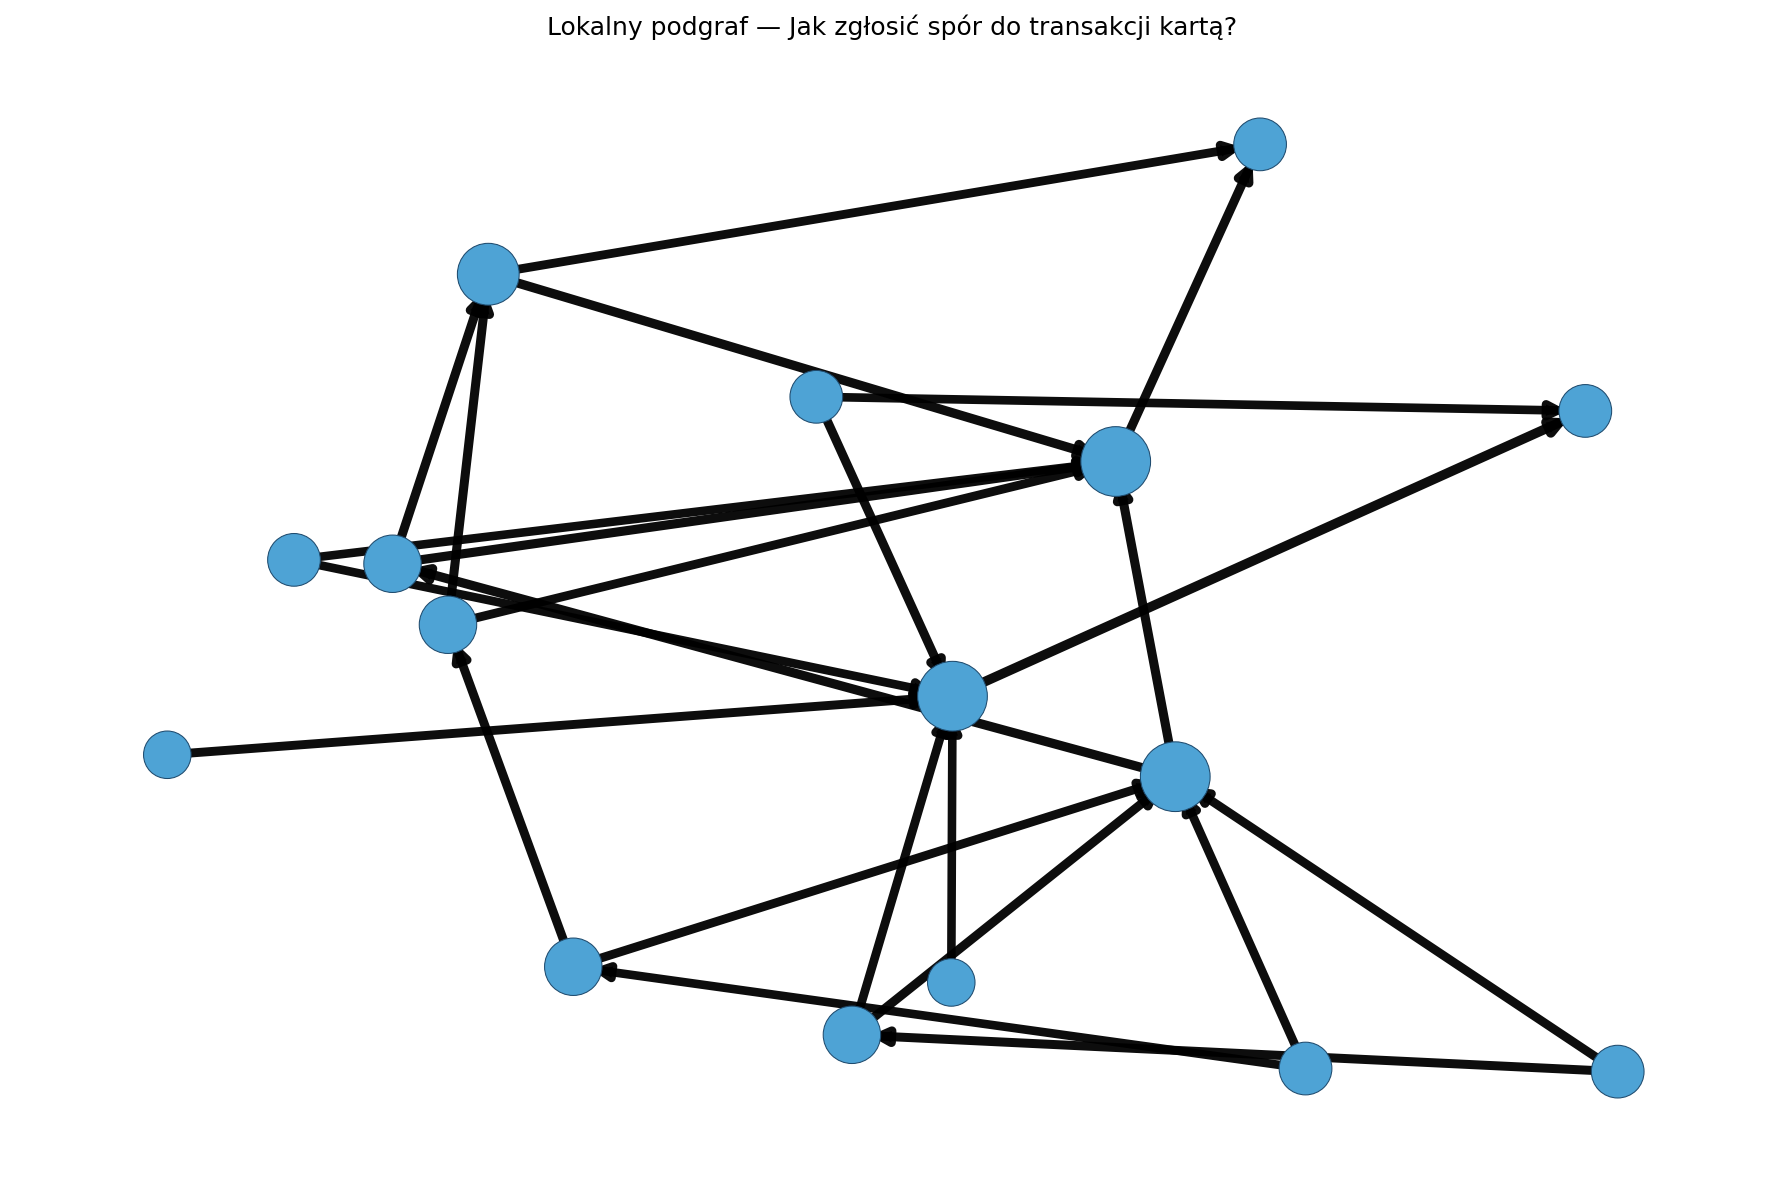

In [12]:
# Budujemy lokalny podgraf z czytelnymi etykietami (wygodne: 'question')
Gq = build_local_subgraph(
    gm,
    query="Jak zgłosić spór do transakcji kartą?",
    top_k=6,
    min_w=0.78,            # jeśli za mało krawędzi, obniż np. do 0.72
    edges_per_node=2,
    label_mode="question", # 'question' albo 'category'
)

# Rysunek z etykietami
draw_graph_pretty(Gq, layout="kk", show_edge_labels=False, title="Lokalny podgraf — Jak zgłosić spór do transakcji kartą?")

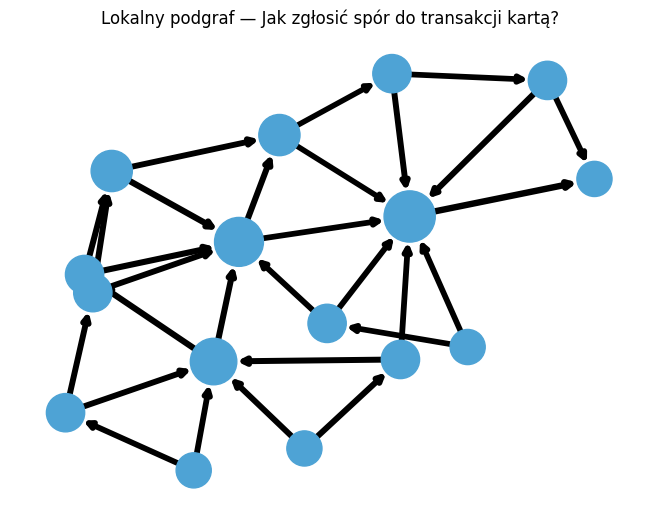

GEXF saved: local_subgraph_chargeback.gexf
Full GEXF saved: full_graph_thresholded.gexf


In [9]:

# DEMO: draw and export
query = "Jak zgłosić spór do transakcji kartą?"
Gq = build_local_subgraph(gm, query=query, top_k=6, min_w=0.70, edges_per_node=2, label_mode="question")
draw_graph(Gq, layout="kk", show_edge_labels=False, title=f"Lokalny podgraf — {query}")
export_gexf(Gq, "local_subgraph_chargeback.gexf")
export_full_graph_gexf(gm, "full_graph_thresholded.gexf", min_w=0.70, max_nodes=2000, label_mode="category")


In [1]:
from memory_qa import build_bot_from_faq
bot = build_bot_from_faq("data/banking_faq_30plus.txt")
bot.answer("Jak zmienić PIN do karty?")

{'answer': 'Nie mam pewnej odpowiedzi w pamięci. Spróbuj doprecyzować pytanie.',
 'candidates': [{'preview': ['[CATEGORY] chargeback',
    'Q: Co to jest chargeback?'],
   'score': 0.34,
   'sim': 0.364,
   'lex': 0.018,
   'recency': 1.0,
   'category': 'chargeback',
   'question': 'Co to jest chargeback?',
   'aliases': ['Czym jest chargeback',
    'Wyjaśnij chargeback',
    'Reklamacja płatności kartą']}]}